<a href="https://colab.research.google.com/github/federicoding/Airline_Satisfaction/blob/main/Airline_Satisfaction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training for a Satisfaction Classification model

Based on Airline flight satisfaction survey data from [Kaggle](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction) and totaly modified by [Tan pengshi Alvin](https://towardsdatascience.com/predicting-satisfaction-of-airline-passengers-with-classification-76f1516e1d16) as published in his blog. More than an inspiration, it's a step-by-step procedure for modeling. And I'll get practical knowledge from it.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, lars_path
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score,roc_auc_score, roc_curve, log_loss, classification_report

from ipywidgets import interactive
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
url='https://raw.githubusercontent.com/federicoding/Airline_Satisfaction/main/Airline_Dataset.csv'
df = pd.read_csv(filepath_or_buffer=url,
                 sep=';')

#Data Preparation
As stated from the blog post, the original data contains around 130k lines (from passengers on US airline flights). In total, 21 feature columns are present and one target binary column. Out of those features, 14 are survey entries where passengers rate the flight experience (with a scale of 1 to 5). Some survey entries have a value of 0, which is infered as unfilled survey questions. Those survey entries, and some other NaN values, are removed resulting in a data set of about 70 000 entries to build the model. It is to be noted that some columns and other entries have been renamed for further clarity.

This is the path of data cleaning.

All in all, **the following changes can be summarized**:



*   Column names are renamed
*   Elements in Feature 'Customer Type' and 'Class' have been renamed
*   Rows with Null values have been removed
*   Rows with scored of 0 in the survey of satisfaction (target column if you want) have been removed (probably due to customers not filling it)
*   Departure Delay end Arrival Delar are combined
*   Satisfaction target is relabelled as 0 and 1


In [5]:
df

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
129876,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0,0.0,satisfied
129877,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
129878,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0,0.0,satisfied


Let's have a rapid look at the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Inflight wifi service              129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Ease of Online booking             129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Food and drink                     1298

Renaming Customer Types
(*NDLR* les titres originaux ne regardent qu'eux...)

In [7]:
df['Customer Type'] = df['Customer Type'].map({'Loyal Customer':'Returning Customer', 'disloyal Customer':'First-time Customer'})

In [8]:
df = df.dropna(axis=0)

In [9]:
df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].astype('float')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129487 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129487 non-null  int64  
 1   Gender                             129487 non-null  object 
 2   Customer Type                      129487 non-null  object 
 3   Age                                129487 non-null  int64  
 4   Type of Travel                     129487 non-null  object 
 5   Class                              129487 non-null  object 
 6   Flight Distance                    129487 non-null  int64  
 7   Inflight wifi service              129487 non-null  int64  
 8   Departure/Arrival time convenient  129487 non-null  int64  
 9   Ease of Online booking             129487 non-null  int64  
 10  Gate location                      129487 non-null  int64  
 11  Food and drink                     1294

In [11]:
df.describe()

,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000,129487.000000
mean,64958.335169,39.428761,1190.210662,2.728544,3.057349,2.756786,2.976909,3.204685,3.252720,3.441589,3.358067,3.383204,3.351078,3.631886,3.306239,3.642373,3.286222,14.643385,15.091129
std,37489.781165,15.117597,997.560954,1.329235,1.526787,1.401662,1.278506,1.329905,1.350651,1.319168,1.334149,1.287032,1.316132,1.180082,1.266146,1.176614,1.313624,37.932867,38.465650
min,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32494.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,64972.000000,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,97415.500000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


Renaming columns

In [12]:
df = df.rename(columns={'Leg room service':'Leg room'})

In [13]:
from string import capwords
df.columns = [capwords(i) for i in df.columns]
df = df.rename(columns={'Departure/arrival Time Convenient':'Departure/Arrival Time Convenience'})

In [14]:
df

,Id,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Departure Delay In Minutes,Arrival Delay In Minutes,Satisfaction
0,70172,Male,Returning Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25.0,18.0,neutral or dissatisfied
1,5047,Male,First-time Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1.0,6.0,neutral or dissatisfied
2,110028,Female,Returning Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0.0,0.0,satisfied
3,24026,Female,Returning Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11.0,9.0,neutral or dissatisfied
4,119299,Male,Returning Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0,0.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,78463,Male,First-time Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,0.0,neutral or dissatisfied
129876,71167,Male,Returning Customer,23,Business travel,Business,646,4,4,4,4,4,4,4,4,4,5,5,5,5,4,0.0,0.0,satisfied
129877,37675,Female,Returning Customer,17,Personal Travel,Eco,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0.0,neutral or dissatisfied
129878,90086,Male,Returning Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,0.0,satisfied


Removing a bunch of **0** valued entries.

In [15]:
df = df[(df['Inflight Wifi Service']!=0)&(df['Departure/Arrival Time Convenience']!=0)&(df['Ease Of Online Booking']!=0)&(df['Gate Location'])&(df['Food And Drink']!=0)&(df['Online Boarding']!=0)&(df['Seat Comfort']!=0)&(df['Inflight Entertainment']!=0)&(df['On-board Service']!=0)&(df['Leg Room']!=0)&(df['Baggage Handling']!=0)&(df['Checkin Service']!=0)&(df['Inflight Service']!=0)&(df['Cleanliness']!=0)]

Relabeling of target and merging of delays

In [16]:
df['Satisfaction'] = df['Satisfaction'].map({'satisfied':1,'neutral or dissatisfied':0})
df = df.reset_index()
df = df.drop('index',axis=1)
df['Total Delay'] = df['Departure Delay In Minutes'] + df['Arrival Delay In Minutes']

Creating a new dataset object

In [17]:
DF = df.copy()
df = df.drop('Id',axis=1)

Re-indexing and dropping unecessary columns

In [18]:
df = df.reindex(columns=['Satisfaction']+list(df.columns)[:-2]+['Total Delay'])
df = df.drop(['Departure Delay In Minutes','Arrival Delay In Minutes'],axis=1)

Checking the Satisfaction (target) column

In [19]:
df['Satisfaction'].value_counts(normalize=True)

0    0.564257
1    0.435743
Name: Satisfaction, dtype: float64

Relabeling some feature values

In [20]:
df['Class'] = df['Class'].map({'Eco':'Economy','Eco Plus':'Economy','Business':'Business'})

In [21]:
df

,Satisfaction,Gender,Customer Type,Age,Type Of Travel,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay
0,0,Male,Returning Customer,13,Personal Travel,Economy,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,43.0
1,0,Male,First-time Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,7.0
2,0,Female,Returning Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,20.0
3,1,Male,Returning Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0
4,0,Female,Returning Customer,26,Personal Travel,Economy,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69061,0,Female,First-time Customer,36,Business travel,Economy,432,1,5,1,3,4,1,4,4,5,2,5,2,3,4,0.0
69062,0,Male,First-time Customer,34,Business travel,Business,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0
69063,0,Female,Returning Customer,17,Personal Travel,Economy,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0
69064,1,Male,Returning Customer,14,Business travel,Business,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0


#Exploration and Analysis of Data & Feature Selection

Some general Data Wrangling to get a better idea (and picture) of the data at hand.

Proportion of classes in the target variable with some splits by Types of [Travel, Customers].

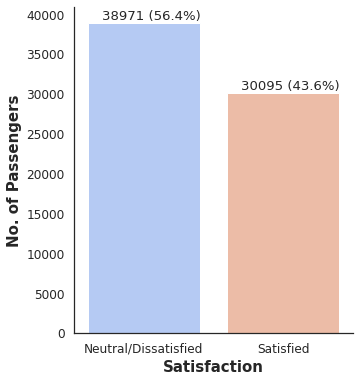

In [22]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',palette='coolwarm')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(str(p.get_height())+' ('+str((p.get_height()/len(df)*100).round(1))+'%)', (p.get_x()+0.1, p.get_height()+400))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
sns.despine()
plt.savefig('targetplot1.png',transparent=True, bbox_inches='tight')

By Type of Travel

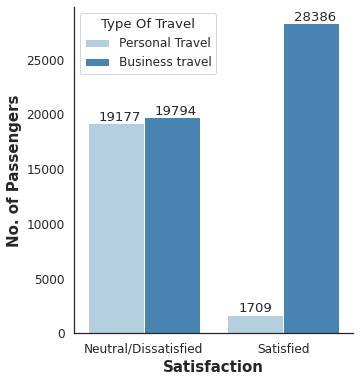

In [23]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',hue='Type Of Travel',palette='Blues')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.08, p.get_height()+200))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
sns.despine()
plt.savefig('targetplot2.png',transparent=True, bbox_inches='tight')

By Type of Customers

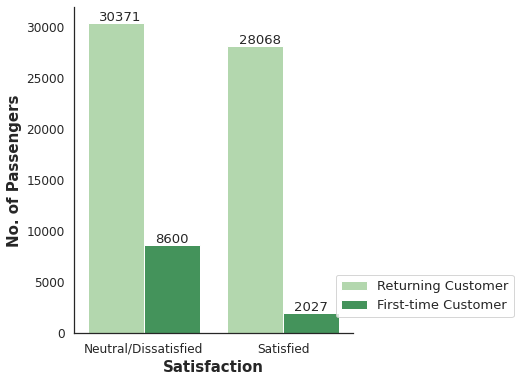

In [24]:
sns.set(style='white',font_scale=1.1)
fig = plt.figure(figsize=[5,6])
ax = sns.countplot(data=df,x='Satisfaction',hue='Customer Type',palette='Greens')
ax.set_xticklabels(['Neutral/Dissatisfied','Satisfied'])
for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x()+0.08, p.get_height()+200))
plt.xlabel('Satisfaction',weight='bold',fontsize='15')   
plt.ylabel('No. of Passengers',weight='bold',fontsize='15')   
plt.legend(loc="upper right", bbox_to_anchor=(1.6, 0.2),fontsize=13)
sns.despine()
plt.savefig('targetplot3.png',transparent=True, bbox_inches='tight')

Note: all checks necessary. At this point I realized a "typo" (No caps in fact) threw over an entire class from the dataset (the 'First-time Customer' one).

Dummie variables for Gender, Customer Type, Type of Travel and Class features.

In [25]:
df1 = pd.get_dummies(df,columns=['Gender','Customer Type','Type Of Travel','Class'],drop_first=True)
df1

,Satisfaction,Age,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay,Gender_Male,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
0,0,13,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,43.0,1,1,1,1
1,0,25,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,7.0,1,0,0,0
2,0,25,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,20.0,0,1,0,0
3,1,61,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0.0,1,1,0,0
4,0,26,1180,3,4,2,1,1,2,1,1,3,4,4,4,4,1,0.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69061,0,36,432,1,5,1,3,4,1,4,4,5,2,5,2,3,4,0.0,0,0,0,1
69062,0,34,526,3,3,3,1,4,3,4,4,3,2,4,4,5,4,0.0,1,0,0,0
69063,0,17,828,2,5,1,5,2,1,2,2,4,3,4,5,4,2,0.0,0,1,1,1
69064,1,14,1127,3,3,3,3,4,4,4,4,3,2,5,4,5,4,0.0,1,1,0,0


Let's have a look at 'Inflight Wifi Service'.

In [26]:
df['Inflight Wifi Service'].value_counts()

3    20681
1    14925
2    13417
5    10977
4     9066
Name: Inflight Wifi Service, dtype: int64

And a look at Satisfaction by flight Class

In [27]:
group = df1.groupby(['Satisfaction','Class_Economy'])['Class_Economy'].count()
group

Satisfaction  Class_Economy
0             0                10710
              1                28261
1             0                23593
              1                 6502
Name: Class_Economy, dtype: int64

##Kernel Density Estimation observation


Usage of this 'generalization' of histograms is called for to observe the distributions of classes in the different features.

May be taxed of being kind of an overshot, but it's a smoth generalization of histograms, so, why not ^^ as it fulfils the very same role of observing data to see some discrepancies.

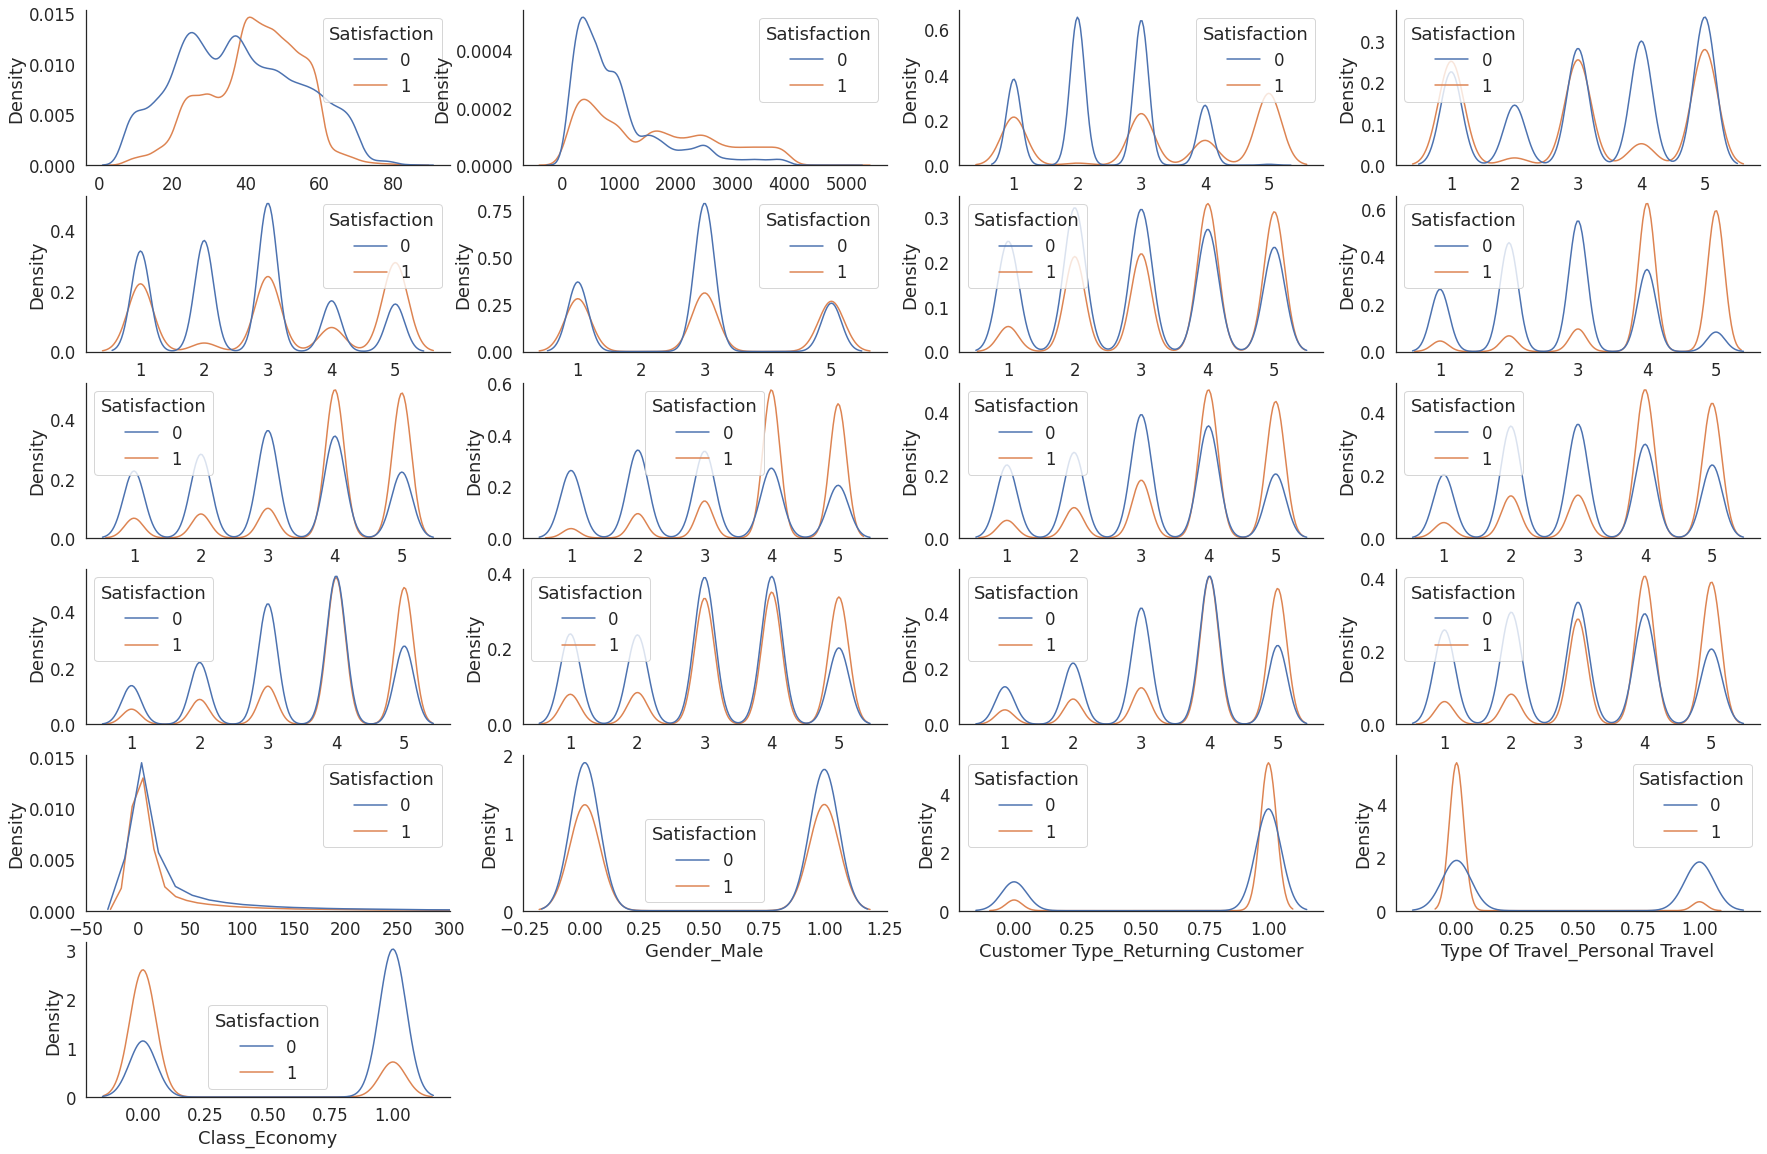

In [28]:
sns.set(style='white',font_scale=1.5)
fig = plt.figure(figsize=[30,20])
for i in range(21):
    fig.add_subplot(6, 4, i+1)
    sns.kdeplot(data=df1,x=df1.columns[i+1],hue='Satisfaction')
    if i == 16:
        plt.xlim([-50,300])
    sns.despine()
    plt.savefig('kdeplot.png',transparent=True, bbox_inches='tight')

From observing those plots we can see, first, that the variable/feature 'Gate Location' contains missing scores, as the classes '2' and '4' are empty. There may have been a problem at some point with data handling (as it is very unlikely that no one picked those 2 scores out of 69k people). Thus this points toward an exclusion of this variable/feature for future models.

We can also see that the variable Gender seems perfectly balanced for both answers, thus very unlikely to be correlated with the response variable. Pointing, again, for an exclusion of this variable in future models.

Correlation matrix and HeatMap

In [29]:
corr_matrix = df1.corr()
corr_matrix

,Satisfaction,Age,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenience,Ease Of Online Booking,Gate Location,Food And Drink,Online Boarding,Seat Comfort,Inflight Entertainment,On-board Service,Leg Room,Baggage Handling,Checkin Service,Inflight Service,Cleanliness,Total Delay,Gender_Male,Customer Type_Returning Customer,Type Of Travel_Personal Travel,Class_Economy
Satisfaction,1.000000,0.150330,0.303677,0.348541,-0.070339,0.204093,0.043578,0.229684,0.566547,0.372681,0.444786,0.345886,0.344405,0.270842,0.237069,0.268040,0.331106,-0.055746,0.012235,0.210703,-0.469940,-0.504920
Age,0.150330,1.000000,0.083523,0.015717,-0.018813,0.017418,0.016286,0.022591,0.190272,0.159516,0.081202,0.064508,0.053213,-0.040651,0.037817,-0.046491,0.055343,-0.016000,0.004828,0.248931,-0.065730,-0.137597
Flight Distance,0.303677,0.083523,1.000000,0.005510,-0.076475,0.050290,0.031325,0.057600,0.195383,0.154670,0.132126,0.115268,0.134143,0.069399,0.074036,0.061872,0.095962,-0.000989,0.001316,0.199221,-0.280260,-0.468605
Inflight Wifi Service,0.348541,0.015717,0.005510,1.000000,0.441308,0.672462,0.443898,0.141383,0.420391,0.135243,0.216028,0.119044,0.151017,0.111939,0.051640,0.102409,0.144782,-0.025515,0.004004,0.012180,-0.119000,-0.039514
Departure/Arrival Time Convenience,-0.070339,-0.018813,-0.076475,0.441308,1.000000,0.576451,0.596772,-0.010922,0.043472,-0.020132,-0.036836,0.061496,-0.005752,0.068147,0.099593,0.069379,-0.004830,-0.005037,0.010184,0.090479,0.257842,0.129964
Ease Of Online Booking,0.204093,0.017418,0.050290,0.672462,0.576451,1.000000,0.599579,0.024465,0.311904,0.024961,0.031309,0.024647,0.079828,0.018964,0.010062,0.017221,0.012290,-0.010531,0.005625,0.028937,-0.122754,-0.104740
Gate Location,0.043578,0.016286,0.031325,0.443898,0.596772,0.599579,1.000000,0.003245,0.025883,0.016101,0.014691,-0.008573,0.009167,-0.001322,-0.023836,-0.004327,0.000937,0.001105,0.002852,0.034772,-0.072084,-0.048318
Food And Drink,0.229684,0.022591,0.057600,0.141383,-0.010922,0.024465,0.003245,1.000000,0.263983,0.565449,0.607716,0.065210,0.035821,0.038652,0.096476,0.038172,0.643129,-0.024135,-0.001328,0.057759,-0.069419,-0.089825
Online Boarding,0.566547,0.190272,0.195383,0.420391,0.043472,0.311904,0.025883,0.263983,1.000000,0.454027,0.318849,0.171895,0.141128,0.100118,0.225618,0.090729,0.366401,-0.033037,-0.044665,0.184988,-0.220551,-0.321064
Seat Comfort,0.372681,0.159516,0.154670,0.135243,-0.020132,0.024961,0.016101,0.565449,0.454027,1.000000,0.607696,0.144117,0.114395,0.082143,0.202177,0.079402,0.674680,-0.029623,-0.031779,0.151569,-0.134707,-0.237519


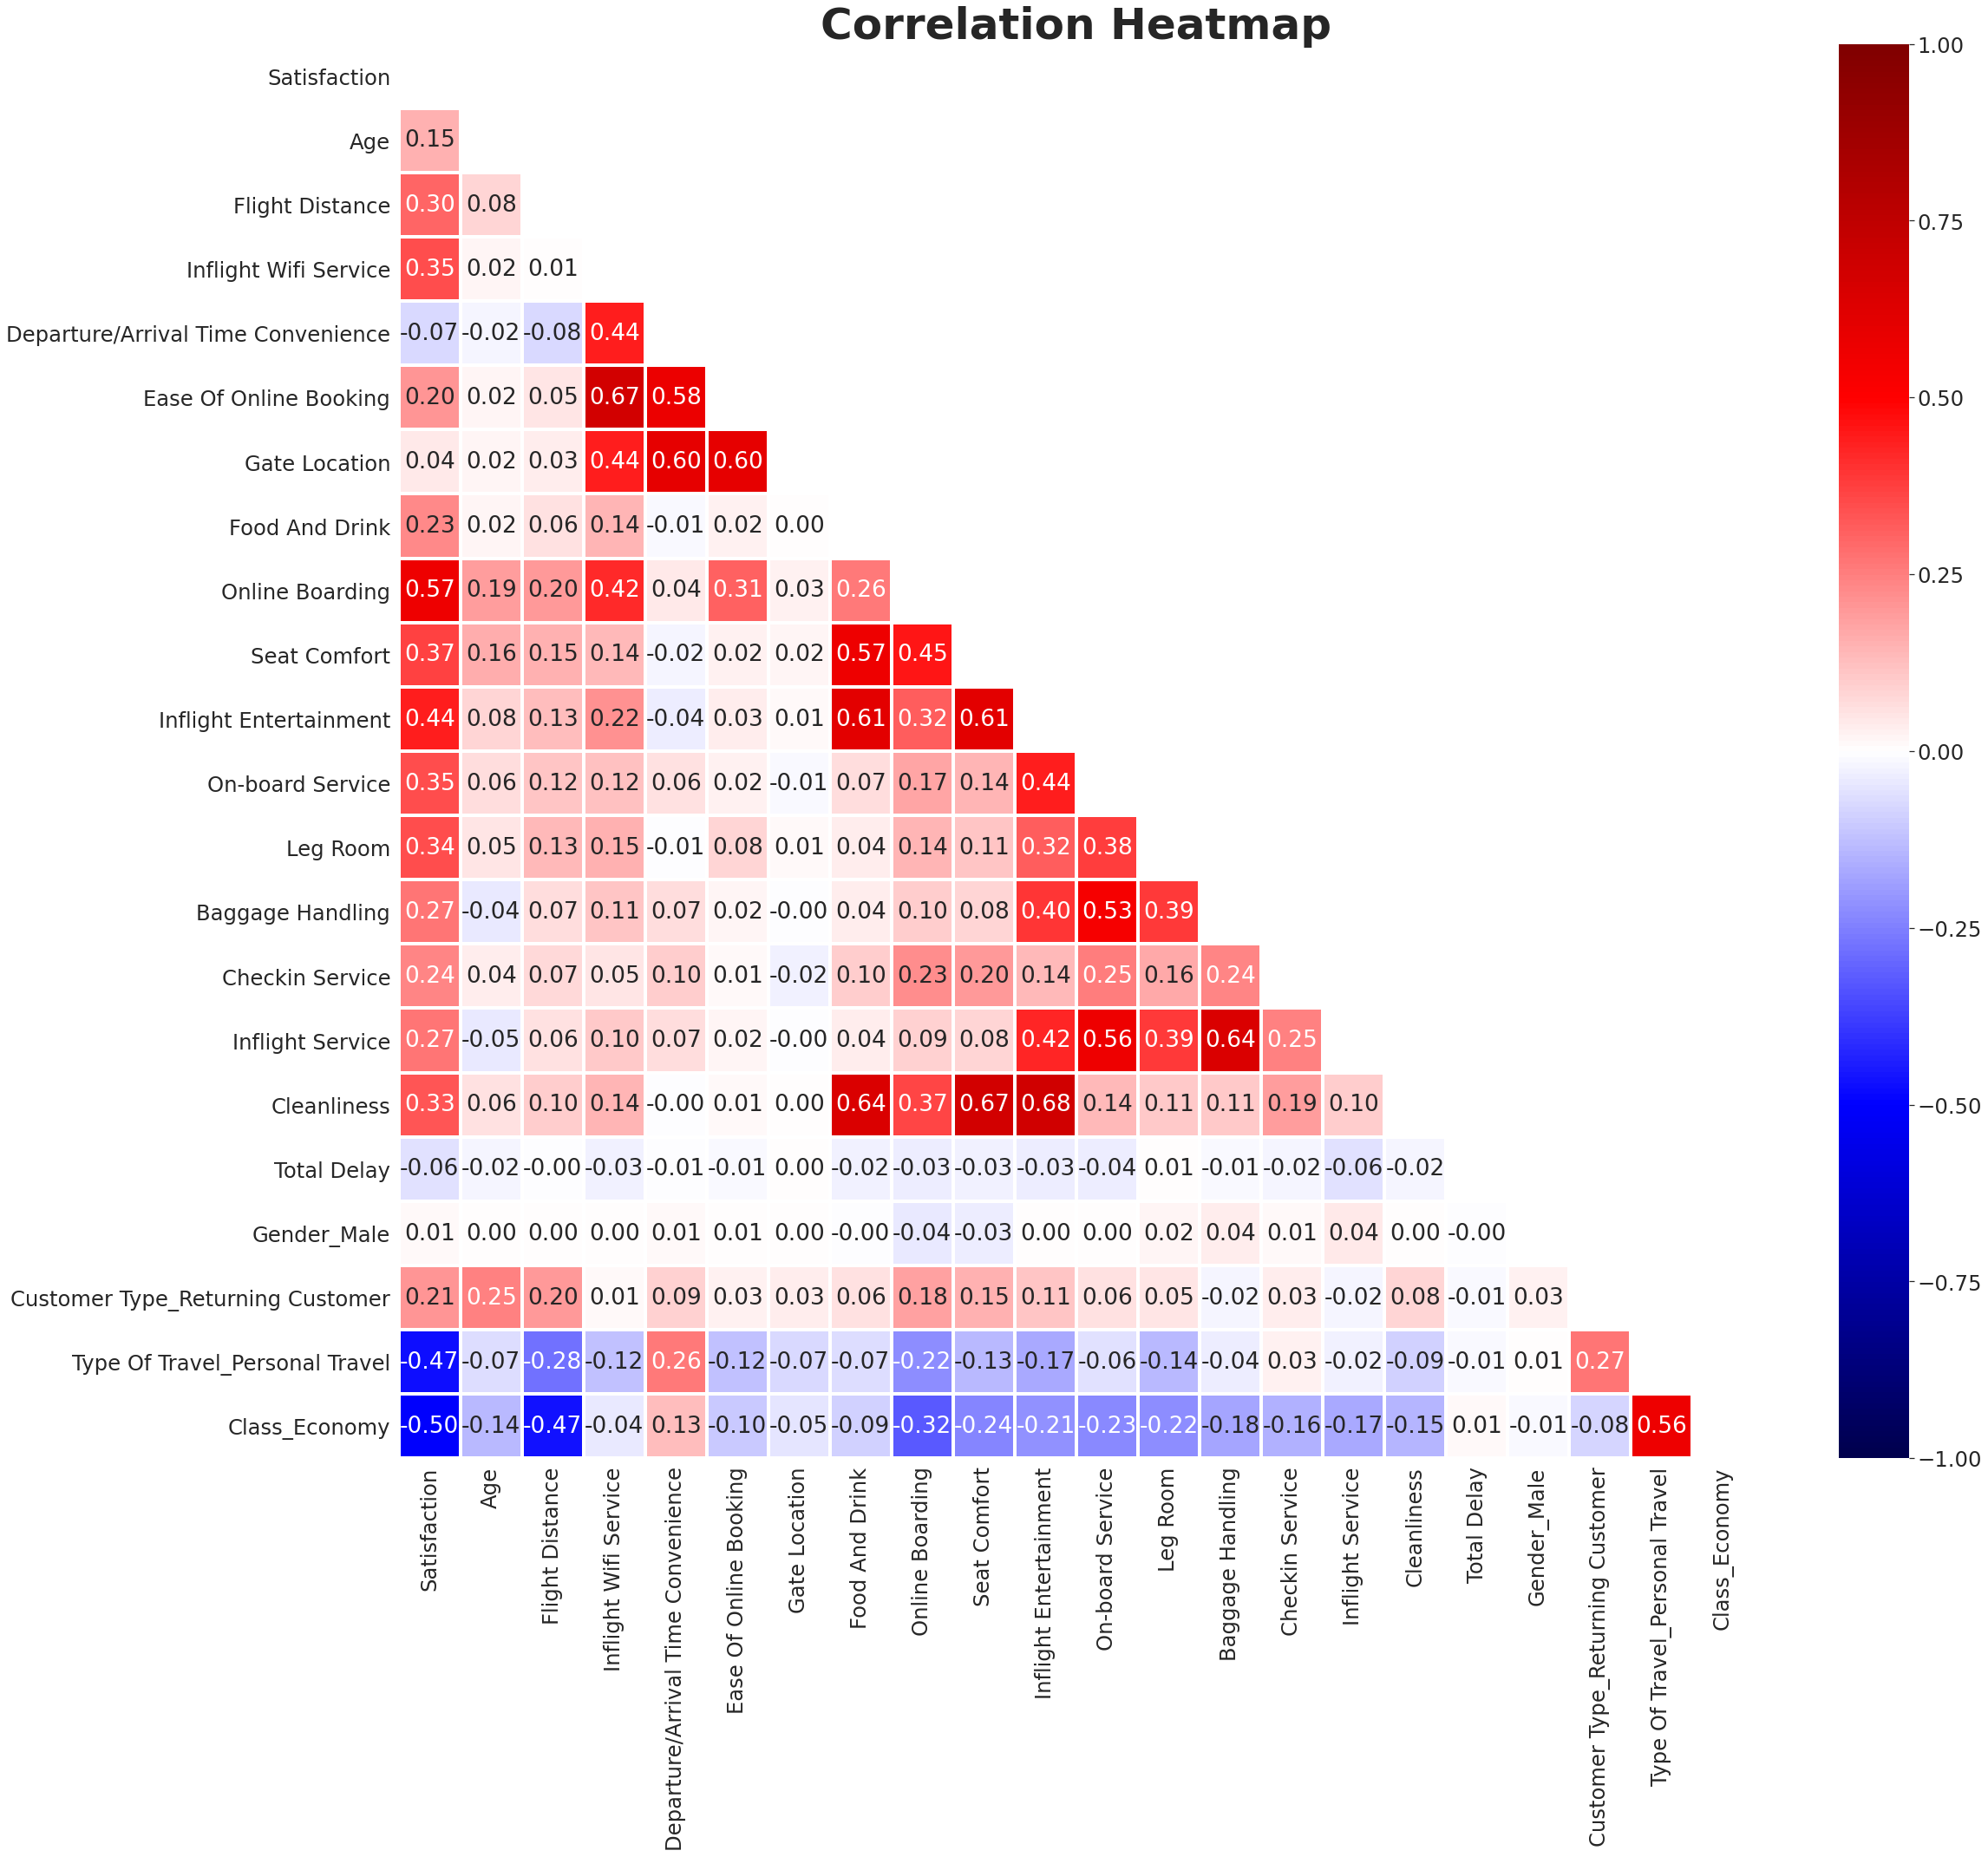

In [30]:
sns.set(style='white',font_scale=2.2)
fig = plt.figure(figsize=[35,30])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(150, 0, as_cmap=True)
sns.heatmap(corr_matrix,cmap='seismic',linewidth=3,linecolor='white',vmax = 1, vmin=-1,mask=mask, annot=True,fmt='0.2f')
plt.title('Correlation Heatmap', weight='bold',fontsize=50)
plt.savefig('heatmap.png',transparent=True, bbox_inches='tight')

The Correlation HeatMap points toward 5 features that have a very low correlation with the target.

Age, Departure/Arrival Time Convenience, Gate Location, Total Delay and Gender_Male are those features. This confirms the pointers towards dropping Gate Location and Gender and add some other candidates to be drop out from the model.

And now, toward LASSO Regression Plot.
The plot will be interpreted to determine the strongest predictors. Variables that enter the model early are the most predictive, those entering latter are less important. And by 'entering the model' we mean the coefficient of this variable gets different from zero earlier (as we increase the lambda term (appearing in the loss function, not shown here).

In [31]:
y = df1['Satisfaction']
X = df1.drop('Satisfaction', axis=1)

In [32]:
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)

In [33]:
lasso_model = Lasso(alpha = 0.01)
selected_columns = list(X.columns)
lasso_model.fit(X, y)
list(zip(selected_columns, lasso_model.coef_))

[('Age', 0.0001314536928149732),
 ('Flight Distance', 2.6269934798460155e-05),
 ('Inflight Wifi Service', 0.05833828264907212),
 ('Departure/Arrival Time Convenience', -0.02570376933241124),
 ('Ease Of Online Booking', -0.0),
 ('Gate Location', -0.0008139404744525452),
 ('Food And Drink', -0.0),
 ('Online Boarding', 0.10613247167886887),
 ('Seat Comfort', 0.0006954566176312904),
 ('Inflight Entertainment', 0.036322816048584776),
 ('On-board Service', 0.03332882517545939),
 ('Leg Room', 0.036451894773713585),
 ('Baggage Handling', 0.012697120797113734),
 ('Checkin Service', 0.028862631954215328),
 ('Inflight Service', 0.010451226725440724),
 ('Cleanliness', 0.011856218721793304),
 ('Total Delay', -0.0002146274063496229),
 ('Gender_Male', 0.0),
 ('Customer Type_Returning Customer', 0.18930324919633668),
 ('Type Of Travel_Personal Travel', -0.28411668082788655),
 ('Class_Economy', -0.08783294972847767)]

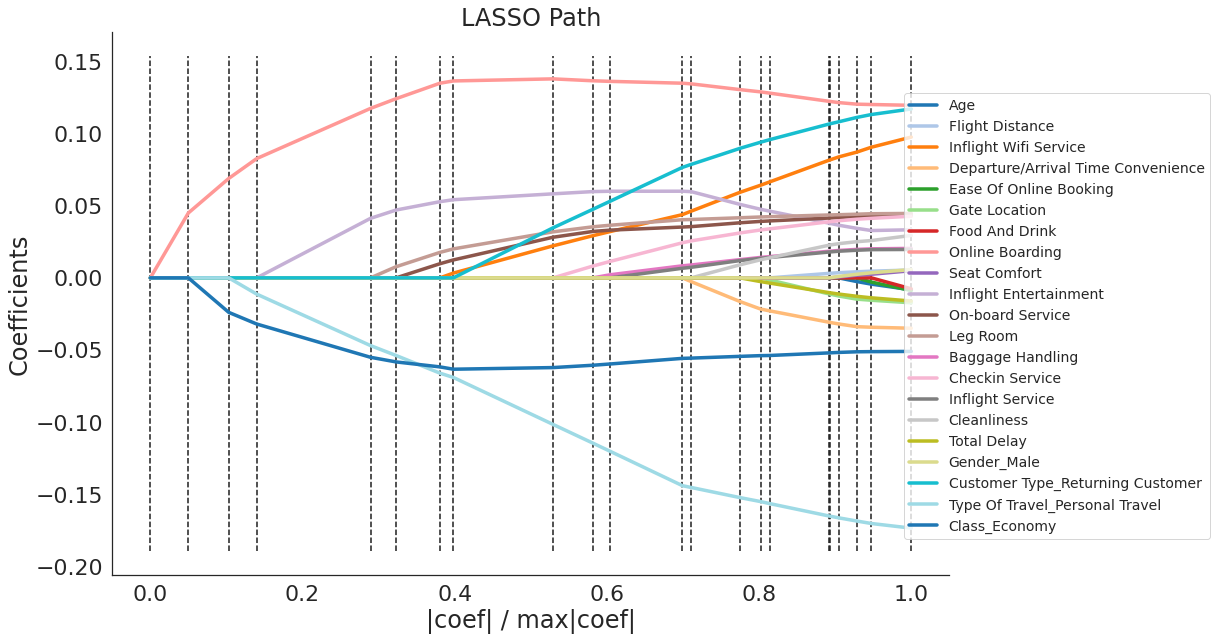

In [34]:
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

from cycler import cycler

# plotting the LARS path
sns.set(style='white',font_scale=2)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.rc('axes', prop_cycle =(cycler(color =['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A',
                                            '#D62728', '#FF9896', '#9467BD', '#C5B0D5', '#8C564B', '#C49C94',
                                            '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7', '#BCBD22', '#DBDB8D',
                                            '#17BECF', '#9EDAE5'])))

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T,linewidth=3.5)

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X.columns,loc="upper right", bbox_to_anchor=(1.32, 0.9),fontsize=14)
sns.despine()
plt.savefig('lassoplot.png',transparent=True, bbox_inches='tight')

From the plot, the least important features seems to be Food and Drink, Easo of Online Booking, Age, Flight Distance, Total Delay, Gate Location and Gender_Male (confirming abose hints and suspicions).


In the end, the **droped features** are the following ones:
* Gender
* Age
* Gate Location
* Total Delay
* Flight Distance
* Departure/Arrival Time Convenience

We are thus left with 15 features for model building.

In [36]:
df1 = df1.drop(['Total Delay','Flight Distance','Age','Gate Location','Departure/Arrival Time Convenience',
                'Gender_Male'],axis=1)

#Model Selection

For model selection purposes the dataset is split into 80% used for 5-fold cross validation and 20% as test for final evaluation of the model. Various classification models are 5-fold cross validated to identify their optimum hyper parameters.


Best model will be found through Regularization with Cross Validation with evaluation with f1-score.

Explored models:
* Logistic Regression (finding out the best C)
* KNN (find out the best k)
* Gaussian Naive Bayes
* Decision Trees (find out the best depth)
* Random Forest (find ou the best depth; and number of trees)
* Ensemble (taking all the models with the best hyperparameters)

Preparation of data and split

In [37]:
y = df1['Satisfaction']
X = df1.drop('Satisfaction',axis=1)

In [38]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

**Logistic Regression**: exploration of Cs, RoC AUC, Precision and Recall

In [39]:
#looking for best C value

Cvec = np.linspace(0.001,2,100)
logit_model = LogisticRegressionCV(Cs = Cvec, cv=kf, max_iter=10000)
logit_model.fit(X_train_val, y_train_val)
logit_model.C_

array([0.04138384])

In [40]:
#RoC AUC
logit_model = LogisticRegression(C=logit_model.C_[0], max_iter=10000)
Mean_AUC_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv= kf, scoring='roc_auc'))
Mean_AUC_Logit_CV

0.9574753417906022

In [41]:
#Precision
Mean_Precision_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_Logit_CV

0.8825738191988528

In [43]:
#Recall
Mean_Recall_Logit_CV = np.mean(cross_val_score(logit_model, X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_Logit_CV

0.8689213943362002

In [45]:
X_train_val = X_train_val.reset_index().drop('index',axis=1)
y_train_val = y_train_val.reset_index().drop('index',axis=1)

#à mon aivs, getting rid of the shuffle

**KNN**: exploration of values of k, RoC AUC, Precision and Recall

In [50]:
score = []
for neighbors in range(5,11):
  f1 = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=neighbors), X_train_val, y_train_val, cv=kf, scoring='f1'))
  score.append(f1)
  print(neighbors)
best_neighbors = list(range(5,11))[np.argmax(score)]
best_f1 = max(score)
print('The best k neighbours is {0} with f1-score of {1}'.format(best_neighbors,best_f1))

5
6
7
8
9
10
The best k neighbours is 7 with f1-score of 0.9275932027728512


In [51]:
Mean_AUC_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_KNN_CV

0.9774336713393126

In [52]:
Mean_Precision_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_KNN_CV

0.9529578915392566

In [54]:
Mean_Recall_KNN_CV = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=7), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_KNN_CV

0.9035544036808725

**Gaussian Naive Bayes**: RoC AUC, Precision and Recall

In [55]:
Mean_AUC_NB_CV =np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_NB_CV

0.9471639267686747

In [56]:
Mean_Precision_NB_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_NB_CV

0.8983471647930287

In [57]:
Mean_Recall_NB_CV = np.mean(cross_val_score(GaussianNB(), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_NB_CV

0.8405343563990776

**Decision Tree**: exploration of depth, RoC AUC, Precision, Recall

In [58]:
score =[]
for depth in range(5,20):
  f1 = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=depth), X_train_val, y_train_val, cv=kf, scoring='f1'))
  score.append(f1)
  print(depth)
best_depth = list(range(5,20))[np.argmax(score)]
best_f1 = max(score)
print('The best depth is {0} with f1-score of {1}'.format(best_depth, best_f1))

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
The best depth is 12 with f1-score of 0.9447723746230625


In [59]:
Mean_AUC_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_tree_CV

0.9788705099231055

In [60]:

Mean_Precision_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_tree_CV

0.9632063830523444

In [61]:
Mean_Recall_tree_CV = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=12), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_tree_CV

0.9271827429527448

**Random Forest Classifier**: depth and number of tree exploration RoC AUC, Precision, Recall

In [67]:
score = []
for depth in range(8,18):
    f1 = np.mean(cross_val_score(RandomForestClassifier(max_depth=depth,random_state=42), X_train_val, y_train_val, cv=kf, scoring='f1'))
    score.append(f1)
    print(depth)
best_depth = list(range(8,18))[np.argmax(score)]  
best_f1 = max(score)
print('The best depth is {0} with f1-score of {1}'.format(best_depth,best_f1))

8
9
10
11
12
13
14
15
16
17
The best depth is 17 with f1-score of 0.9539426403192326


In [63]:
parameters = {'n_estimators':[170,200,230],'max_depth':[10,15,17],'random_state':[42]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf,parameters,scoring='f1')
clf

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [64]:
clf.fit(X_train_val, y_train_val)
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [65]:
clf.best_score_

0.9550222398681113

Not a significant improvement.



In [68]:
Mean_AUC_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_forest_CV

0.9929174756792903

In [69]:
Mean_Precision_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_forest_CV

0.9727655008898376

In [70]:
Mean_Recall_forest_CV = np.mean(cross_val_score(RandomForestClassifier(max_depth=17,random_state=42), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_forest_CV

0.9358494068346458

**Ensemble Models**

In [71]:
Log_Model = LogisticRegression(C=0.04138384,max_iter=10000)
KNN_Model = KNeighborsClassifier(n_neighbors=7)
NB_Model = GaussianNB()
Tree_Model = DecisionTreeClassifier(max_depth=12)
Forest_Model = RandomForestClassifier(max_depth=17,random_state=42)

model_list = [Log_Model,KNN_Model,NB_Model,Tree_Model,Forest_Model]
model_names = ["log_model", "knn_model", "nb_model", "tree_model", "forest_model"]
model = list(zip(model_names, model_list))

In [72]:
Mean_AUC_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='roc_auc'))
Mean_AUC_ensemble_CV

0.9878463702973374

In [73]:
Mean_Precision_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='precision'))
Mean_Precision_ensemble_CV

0.9609968468496742

In [74]:
Mean_Recall_ensemble_CV = np.mean(cross_val_score(VotingClassifier(estimators=model,voting='soft',n_jobs=-1), X_train_val, y_train_val, cv=kf, scoring='recall'))
Mean_Recall_ensemble_CV

0.9180764292588522

**Visualisation of results**

In [75]:
model = ['Logistic Regression','KNN','Gaussian NB','Decision Trees','Random Forest','Ensemble']
scoring = ['AUC','Precision','Recall']
model_name = ['Logit','KNN','NB','tree','forest','ensemble']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('Mean_{0}_{1}_CV'.format(j,model_name[model.index(i)]))}
        model_list.append(model_dic)

In [76]:
model_df = pd.DataFrame(model_list)
model_df

,Model,Scoring,Score
0,Logistic Regression,AUC,0.957475
1,Logistic Regression,Precision,0.882574
2,Logistic Regression,Recall,0.868921
3,KNN,AUC,0.977434
4,KNN,Precision,0.952958
5,KNN,Recall,0.903554
6,Gaussian NB,AUC,0.947164
7,Gaussian NB,Precision,0.898347
8,Gaussian NB,Recall,0.840534
9,Decision Trees,AUC,0.978871


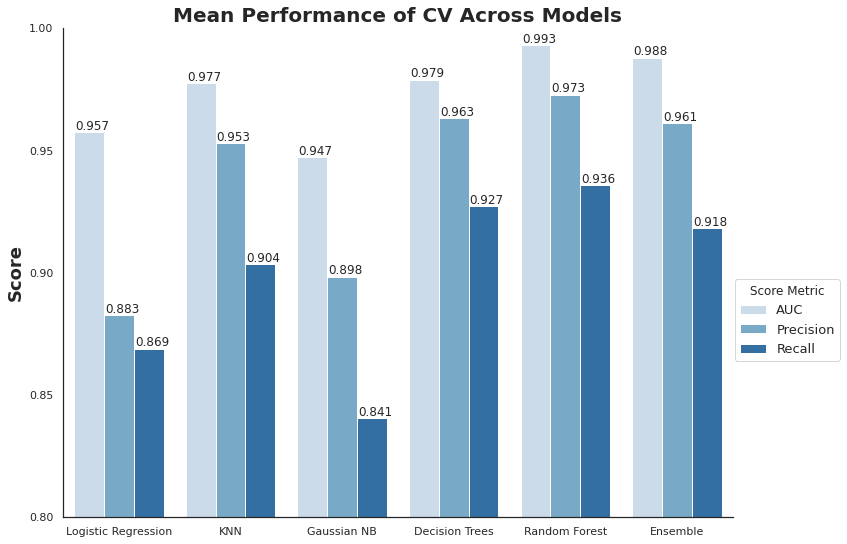

In [77]:

sns.set(style='white',font_scale=1)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.01, p.get_height()+0.001))
plt.legend(title='Score Metric',loc="upper right", bbox_to_anchor=(1.17, 0.5),fontsize=13)
plt.ylim([0.8,1.0])
plt.yticks([0.80,0.85,0.90,0.95,1.00])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Mean Performance of CV Across Models',weight='bold',fontsize=20)
sns.despine()
plt.savefig('modelbarplot.png',transparent=True, bbox_inches='tight')

**Random Forest** is the selected model.

As our model aims to correctly identify crucial factors leading to customer satisfaction, having high Precision is important. Because of the Precision-Recall trade off from adjustement of the probability threshold, further simple validation in the Random Forest Model is done to decide on the optimum probability threshold.

Retraining on 60% of the data set and scoreing on 20% (both accounting for the 80% used as first-training set, the test set is left untouched).

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,random_state=42)

In [79]:
rf = RandomForestClassifier(max_depth=17, random_state=42)
rf.fit(X_train,y_train)
print("Random Forest score: {:.4f}".format(rf.score(X_train,y_train)))

Random Forest score: 0.9864


Playing with two values of probability threshold

In [80]:
y_predict = rf.predict_proba(X_val)[:, 1] >= 0.5
precision_05 = precision_score(y_val, y_predict)
precision_05

0.9744755244755244

In [81]:
recall_05=recall_score(y_val, y_predict)
recall_05

0.9363346211993953

In [83]:
#interactive(lambda threshold: make_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.02))

In [84]:
y_predict = rf.predict_proba(X_val)[:, 1] >= 0.7
precision_07 = precision_score(y_val, y_predict)
precision_07

0.9933530280649926

In [85]:
recall_07=recall_score(y_val, y_predict)
recall_07

0.9037460104149169

In [86]:
roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

0.9927987107661415

In [87]:
SV_model = [{'Scoring':'Precision','Threshold':0.5,'Score':precision_05},{'Scoring':'Precision','Threshold':0.7,'Score':precision_07},{'Scoring':'Recall','Threshold':0.5,'Score':recall_05},{'Scoring':'Recall','Threshold':0.7,'Score':recall_07}]
SV_model = pd.DataFrame(SV_model)
SV_model

,Scoring,Threshold,Score
0,Precision,0.5,0.974476
1,Precision,0.7,0.993353
2,Recall,0.5,0.936335
3,Recall,0.7,0.903746


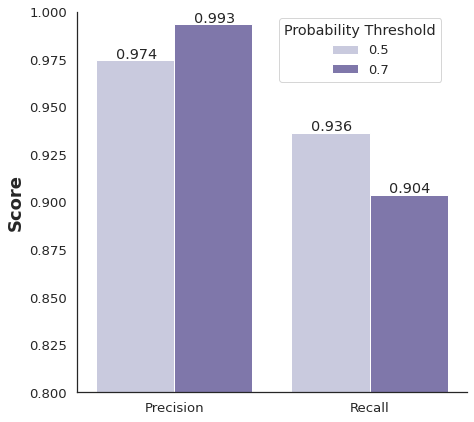

In [88]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[7,7])
ax = sns.barplot(x='Scoring',y='Score',data=SV_model,hue='Threshold',palette='Purples')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.1, p.get_height()+0.001))
plt.legend(title='Probability Threshold',loc="upper right", bbox_to_anchor=(0.95, 1),fontsize=13)
plt.ylim([0.8,1.0])
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
sns.despine()
plt.savefig('probabilityplot.png',transparent=True, bbox_inches='tight')